## Biological analysis of gene subspaces

In [ ]:
import ggml_ot
import scanpy as sc
import numpy as np

In this tutorial, we explore the biological interpretation of the model learned with `ggml_ot`. We demonstrate functions to compute and visualize:
- low-dimensional cell embedding in the learned subspace
- gene ranking for each component
- gene enrichment analysis for each component



Load the data (Myocardial Infarction dataset from Kuppe et. al, 2022) and train the model as before.

Compute all OT distances after 10 iterations


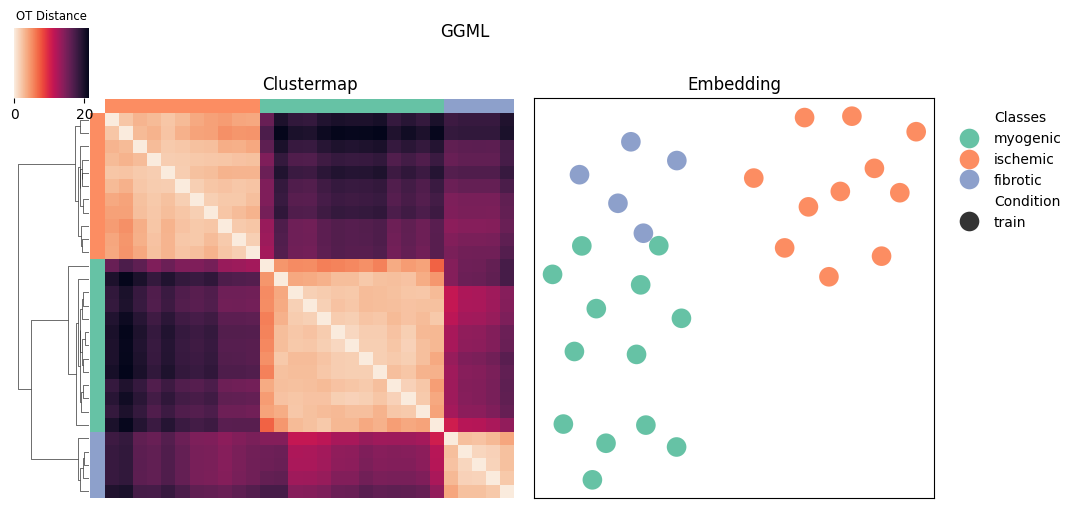

In [2]:
id = "c1f6034b-7973-45e1-85e7-16933d0550bc.h5ad"
adata = ggml_ot.data.load_cellxgene(id)
sc.pp.highly_variable_genes(adata,n_top_genes=5000,subset=True)

dataset = ggml_ot.from_anndata(adata)
dataset.train(n_comps=2, verbose=False,n_threads=100)

Here, we see the patient-level OT distances with the learned ground metric capture the patient's disease states.

## Learned Gene Subspace

Let's have a look at the cell-level distances of the learned ground metric, i.e. the cells in the learned low-dimensional gene subspace that captures the patient's disease state under OT.

Here, we plot "COL8A1" and "EMC10" as example marker genes for myocardial infarction. In the next section, we demonstrate how to identify literature-supported marker genes by ranking genes according to their X_ggml loadings.

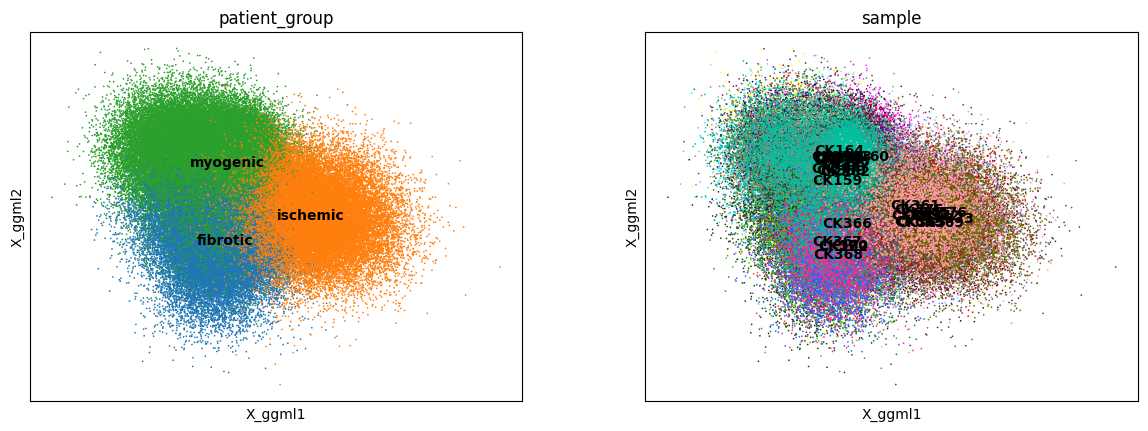

In [56]:
adata = dataset.adata

# Show cells embedded in low-dimensional gene subspace (adata.obsm["X_ggml"])
sc.pl.embedding(adata,basis="X_ggml",color=["patient_group","sample"], 
                s=6,gene_symbols="feature_name",use_raw=False,ncols=2,legend_loc='on data') 

Compare this to a traditional UMAP of the full gene space.

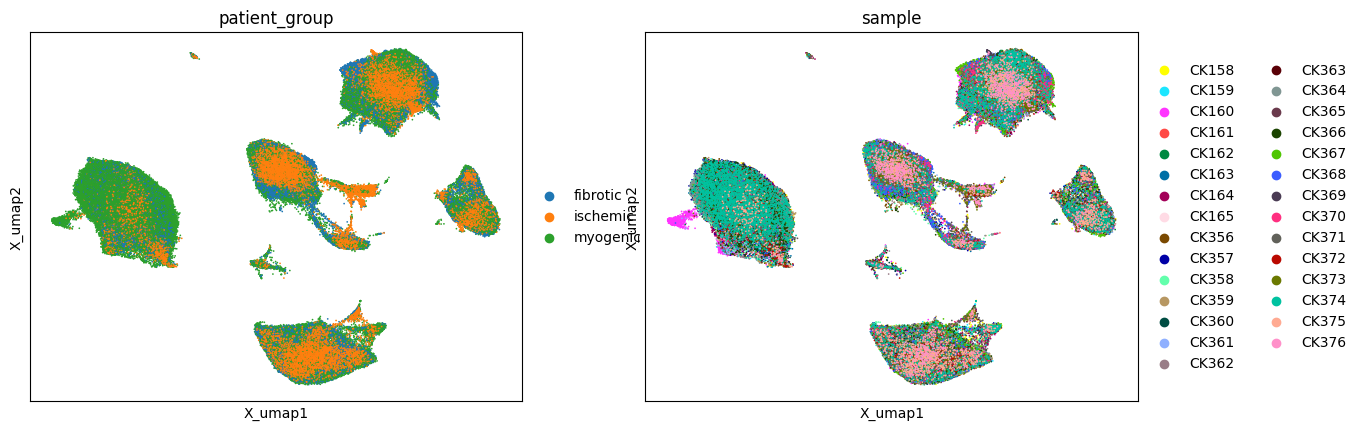

In [57]:
# Show cells embedded in low-dimensional gene subspace (adata.obsm["X_ggml"])
sc.pl.embedding(adata,basis="X_umap",color=["patient_group","sample"], 
                s=6,gene_symbols="feature_name",use_raw=False,ncols=2) 

## Gene ranking in GGML loadings

The function ``gene.ranking`` ranks the genes for each component of the learned gene subspace. It behaves like `scanpy.pl.pca_loadings`, but on `.varm["W_ggml"]` instead of `.varm["PCs]`.

Here, we plot the top 50 genes for each component.

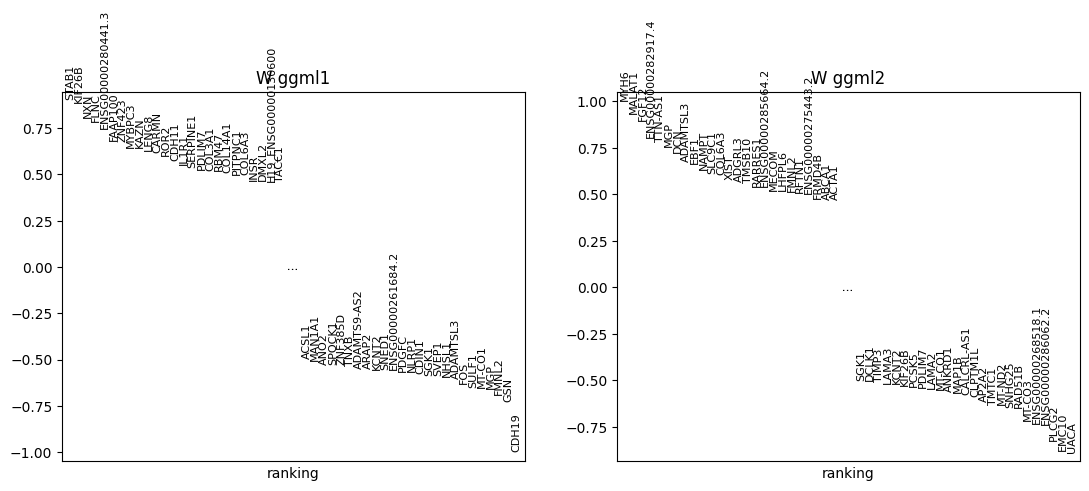

In [5]:
ggml_ot.gene.ranking(adata,gene_symbols="feature_name",n_genes=50)

We can also look at the top ranked genes in the learned gene subspace. Keep in mind that both positive and negative values with a high magnitude have a high importance for the corresponding loading.

In [137]:
genes_per_loading = 3

# Get index of genes with the largest (absolute) score for each loading
top_ranked_ind = np.argsort(np.abs(adata.varm["W_ggml"]), axis=0)[-genes_per_loading:,:]

# Get corresponding gene names
top_ranked_genes = list(adata.var.feature_name[np.flip(top_ranked_ind,axis=0).flatten(order="F")])
print(top_ranked_genes)

['CDH19', 'STAB1', 'KIF26B', 'MYH6', 'MALAT1', 'FGF12']


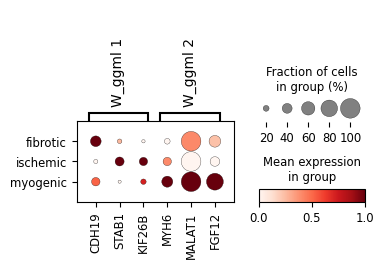

In [173]:
# prepare group annotation of top genes to resp. GGML loadings
n_comps = adata.varm["W_ggml"].shape[-1]
comp_group_pos = [tuple(p+c*genes_per_loading for p in (0,genes_per_loading-1)) for c in range(n_comps)]
comp_group_label = [f"W_ggml {1 + i}" for i in range(n_comps)]

# plot gene expression of top ranked genes across disease states
sc.pl.dotplot(adata, top_ranked_genes, groupby='patient_group',gene_symbols="feature_name", standard_scale="var",
              var_group_positions=comp_group_pos, var_group_labels=comp_group_label)

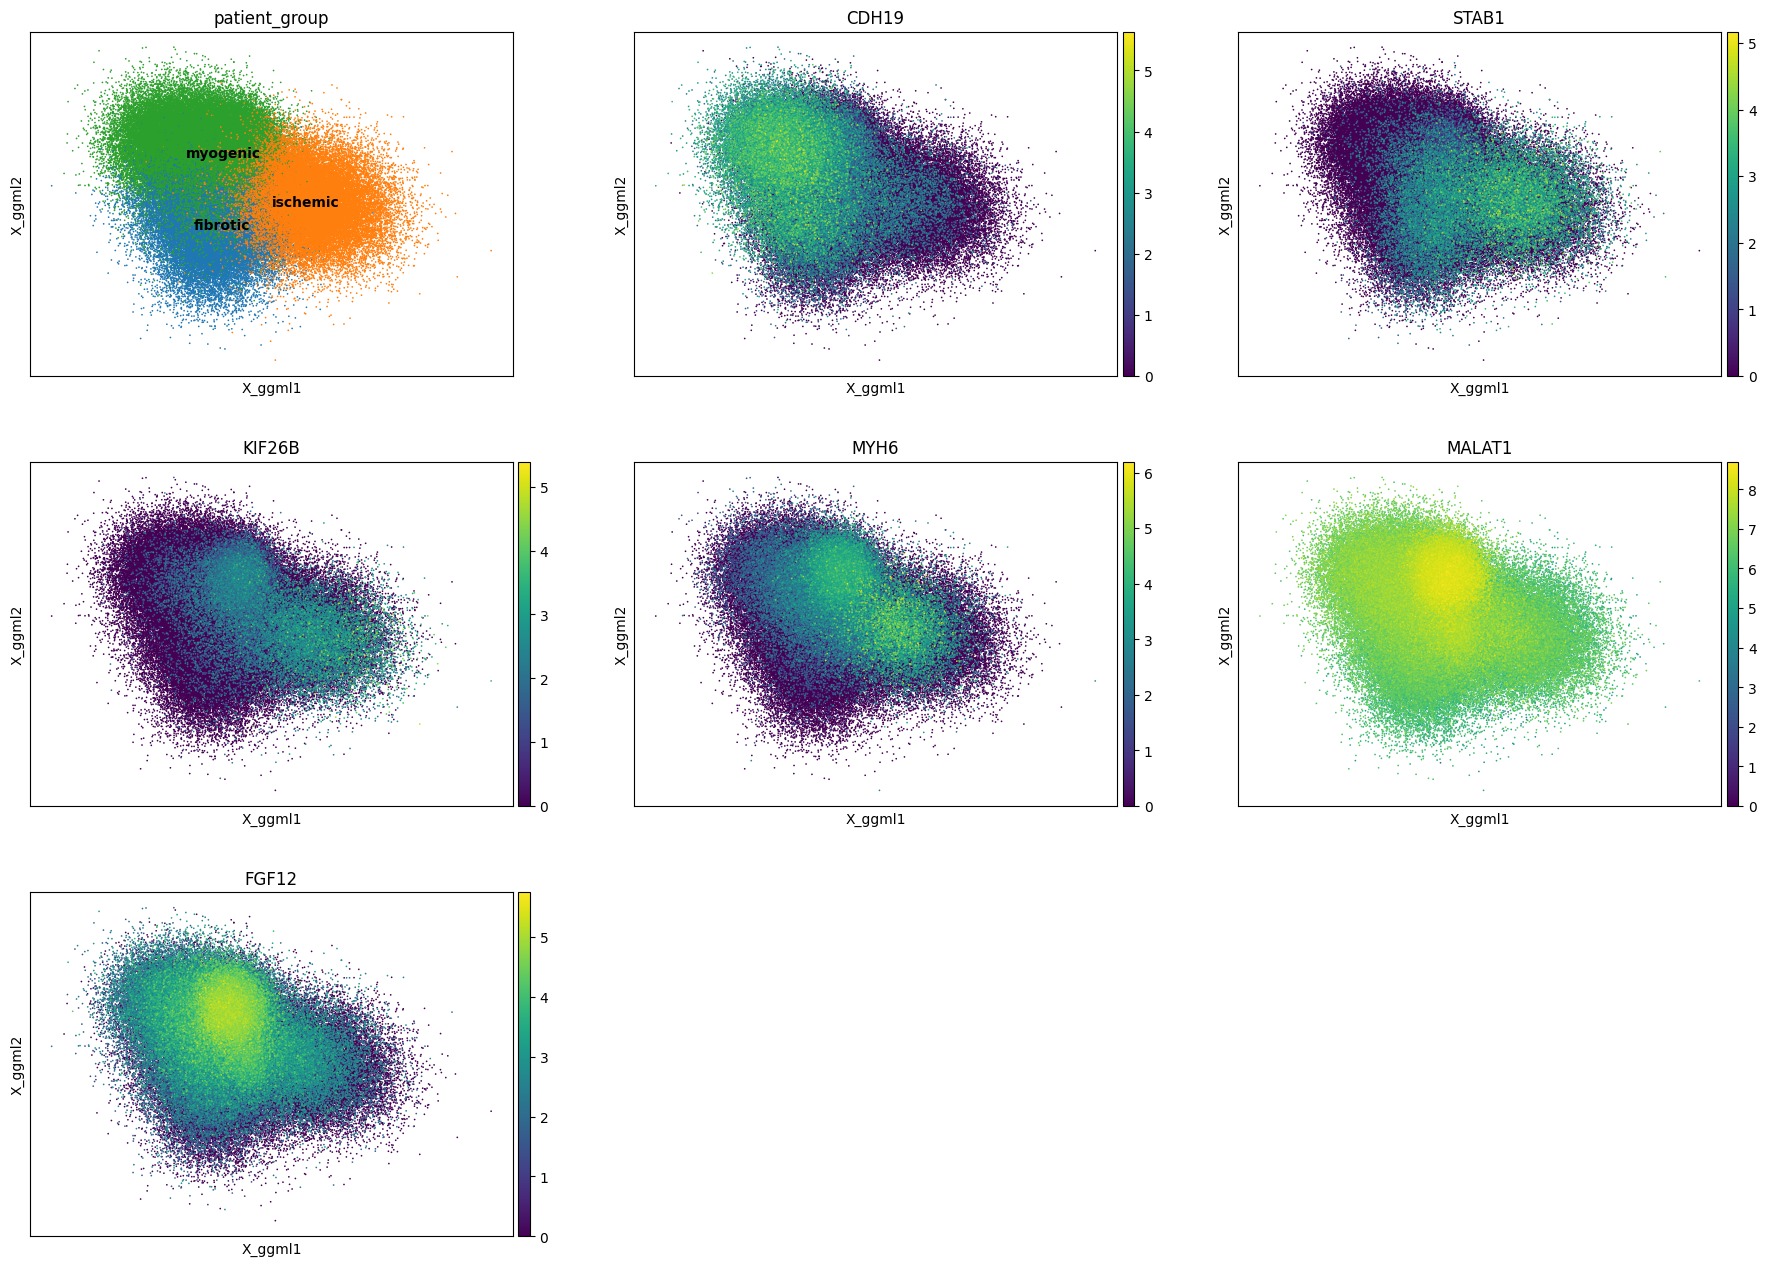

In [138]:
sc.pl.embedding(adata,basis="X_ggml",color=["patient_group"] + top_ranked_genes, 
                s=6,gene_symbols="feature_name",use_raw=False,ncols=3,legend_loc='on data') 

And compare this against the UMAP projection of the full gene space. 

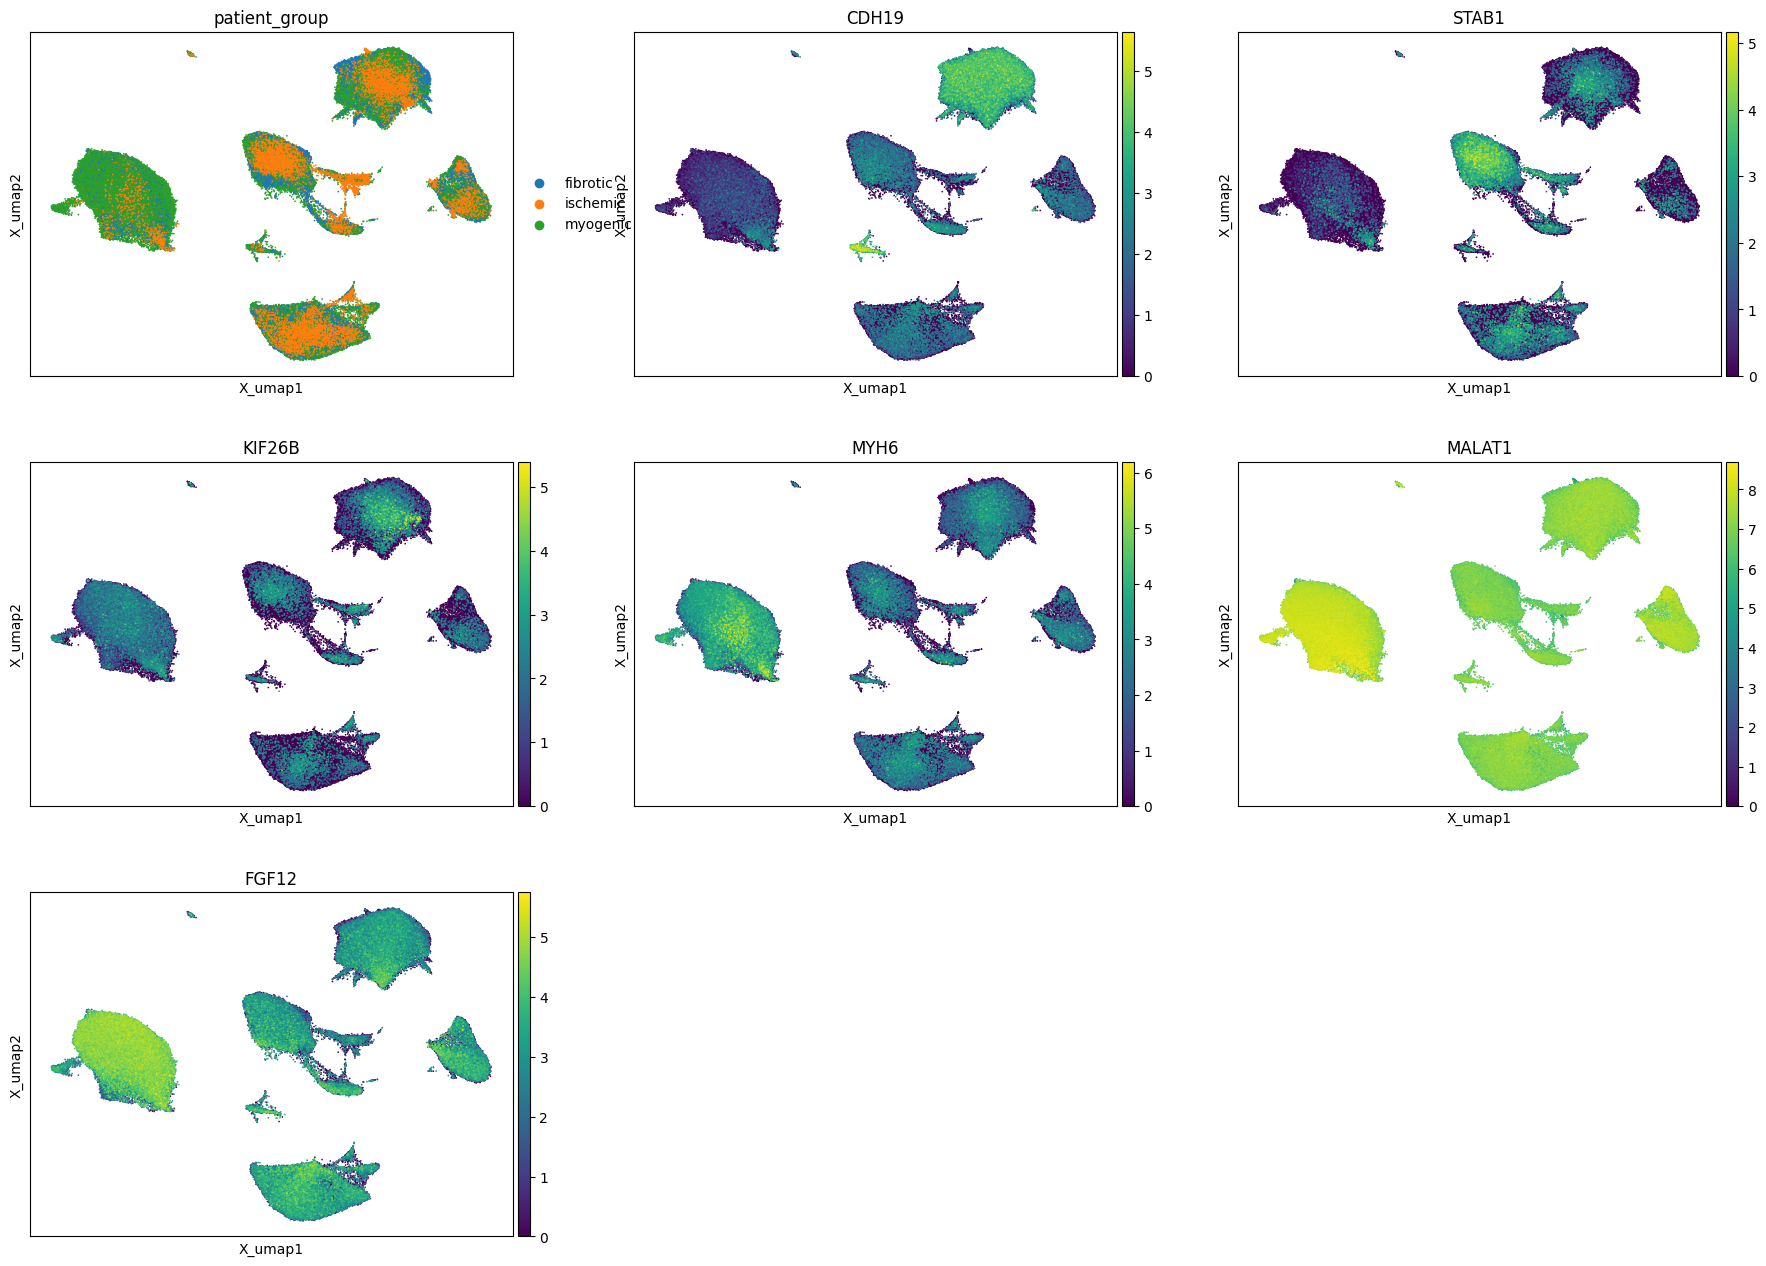

In [139]:
sc.pl.embedding(adata,basis="X_umap",color=["patient_group"]+ top_ranked_genes, 
                s=6,gene_symbols="feature_name",ncols=3,use_raw=False) 

## Gene enrichment of GGML loadings

With ``gene.enrichment()``, we take the most important genes from each loading and check if they are linked to known biological processes. 

In the following, we consider top 50 genes for each loading and perform gene enrichment analysis. By default, we consider the ordering of the gene ranking (`ordered=True`)

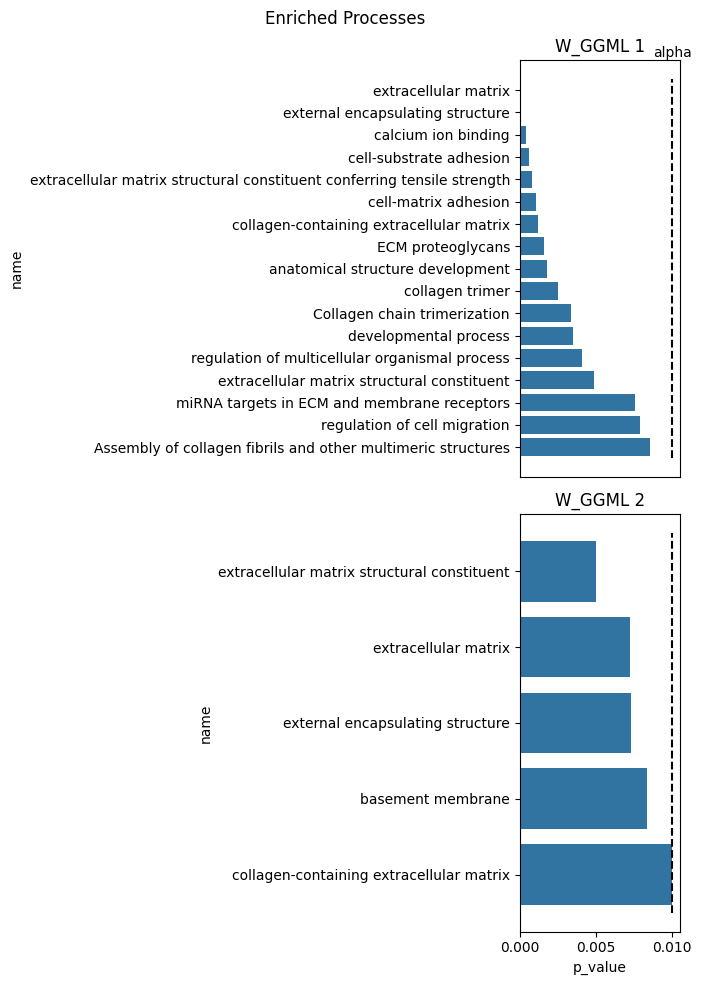

In [140]:
ggml_ot.gene.enrichment(adata,gene_symbols="feature_name",n_genes=50,alpha=0.01)

## Cell type-specific analysis

While ggml_ot learns a global metric across all cell types, we can investigate the top ranked genes in GGML loadings specifically for the cell types that express these genes. Here, we consider 3 top ranked genes from each loading and show their expression across cell types.

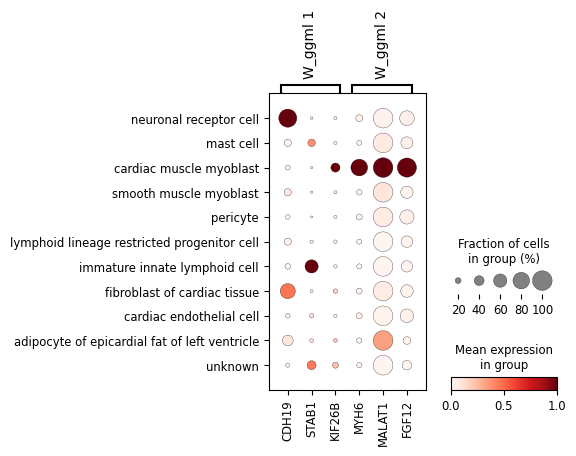

In [168]:
# plot gene expression of top ranked genes across cell types
sc.pl.dotplot(adata, top_ranked_genes, groupby='cell_type',gene_symbols="feature_name", standard_scale="var",
              var_group_positions=comp_group_pos, var_group_labels=comp_group_label)

And look at the gene expression in embeddings only for expressed cell_types.

In [183]:
# Here we select which top ranked genes to plot for which cell types
selected_genes = {
    "fibroblast of cardiac tissue": ["CDH19"],
    "immature innate lymphoid cell":  ["STAB1"],
    "cardiac muscle myoblast": ["MYH6","MALAT1","FGF12","KIF26B"],
}

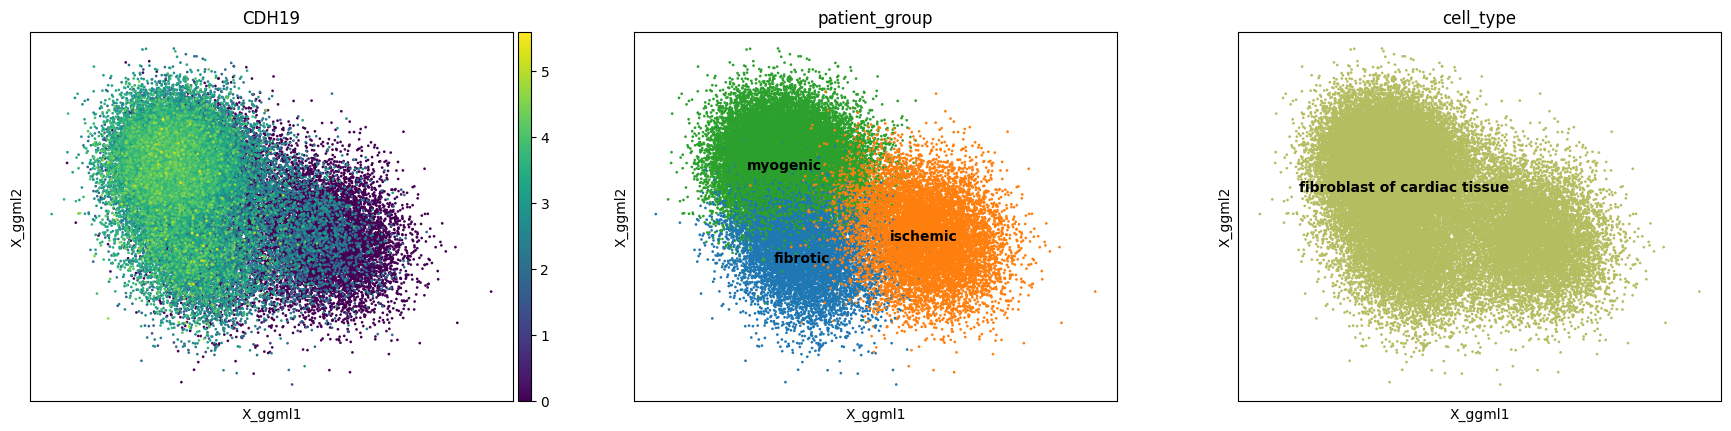

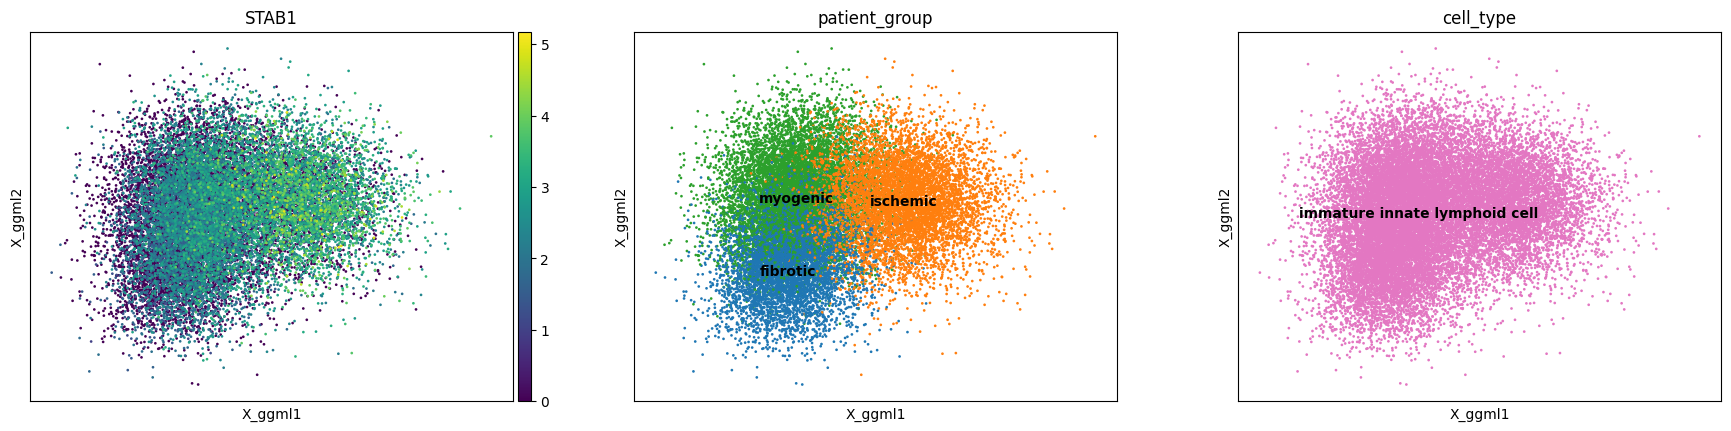

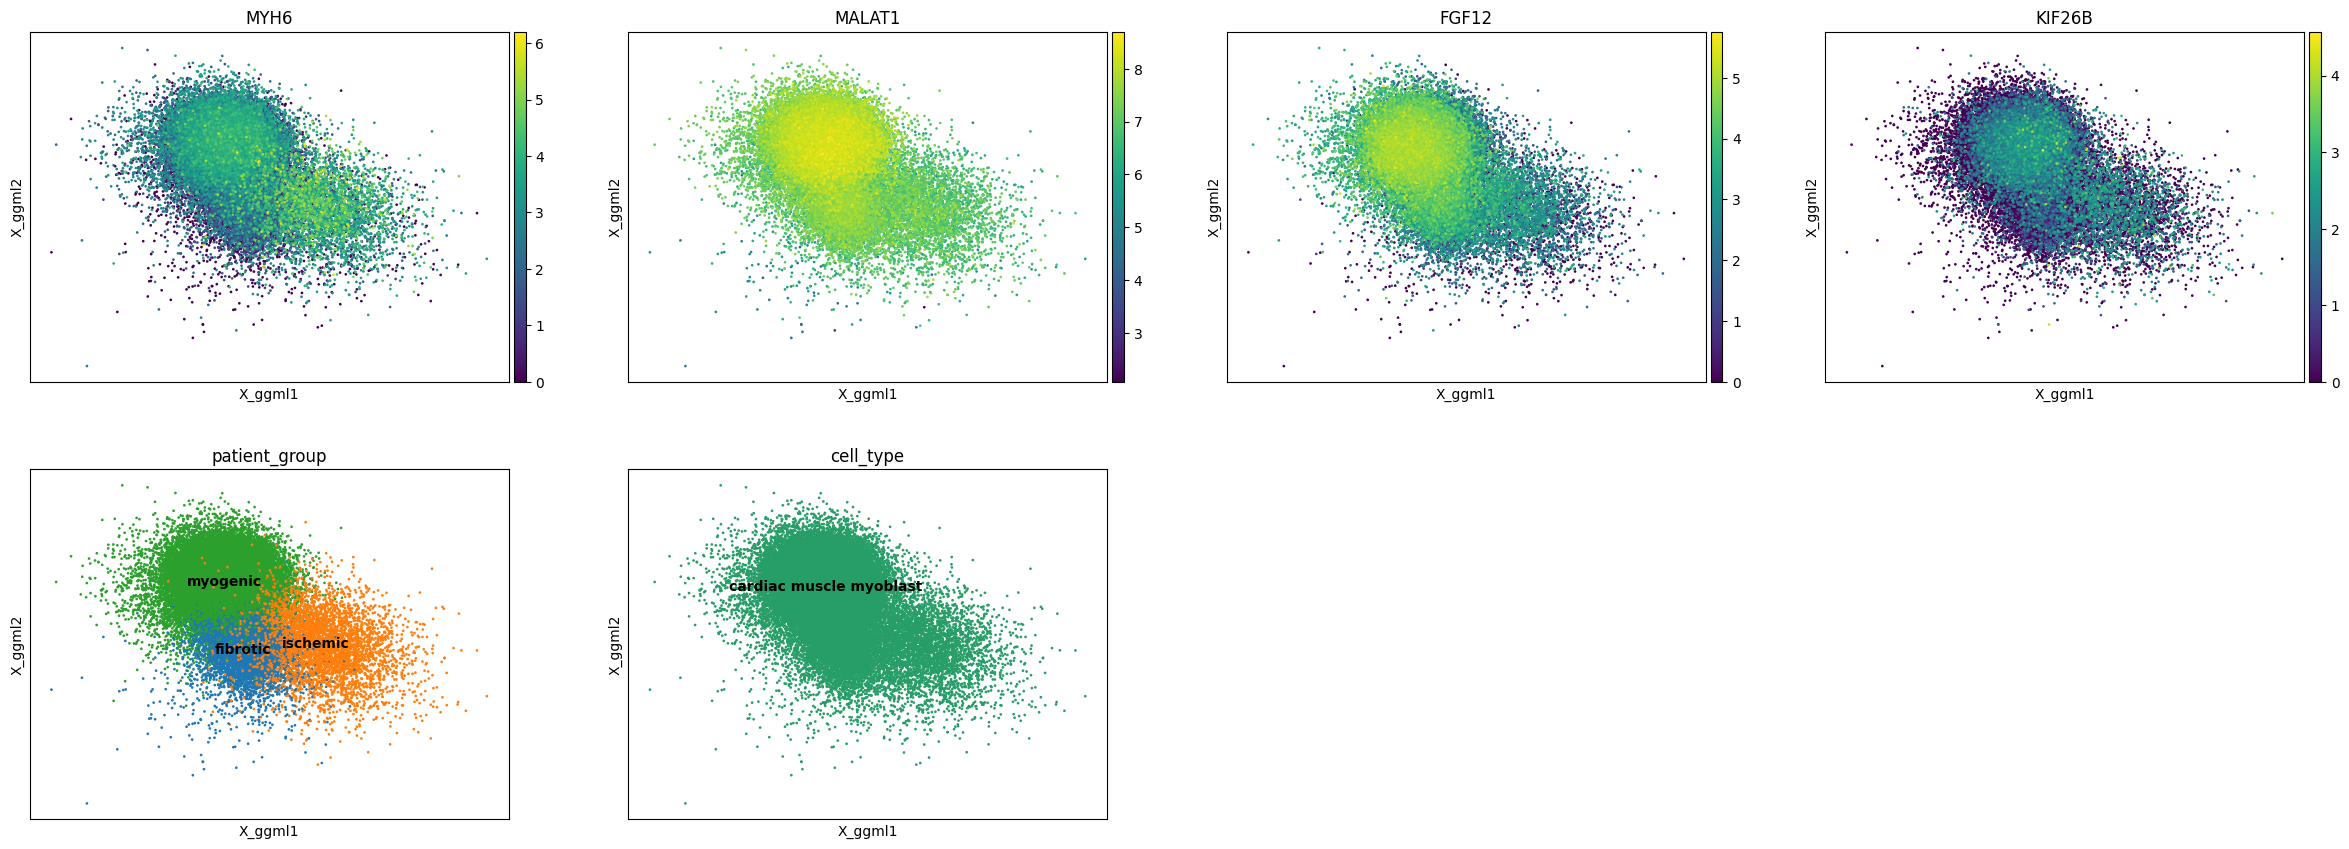

In [184]:
# And plot the embeddings
emb = "X_ggml"
for celltype in selected_genes.keys():
    # Subset view of cell type 
    sub_adata = adata[adata.obs["cell_type"]==celltype]

    # Plot embedding on subset of cell type
    sc.pl.embedding(sub_adata,basis=emb,color=selected_genes[celltype]+["patient_group","cell_type"],
                    gene_symbols="feature_name", use_raw=False, s=15, legend_loc='on data') 
    

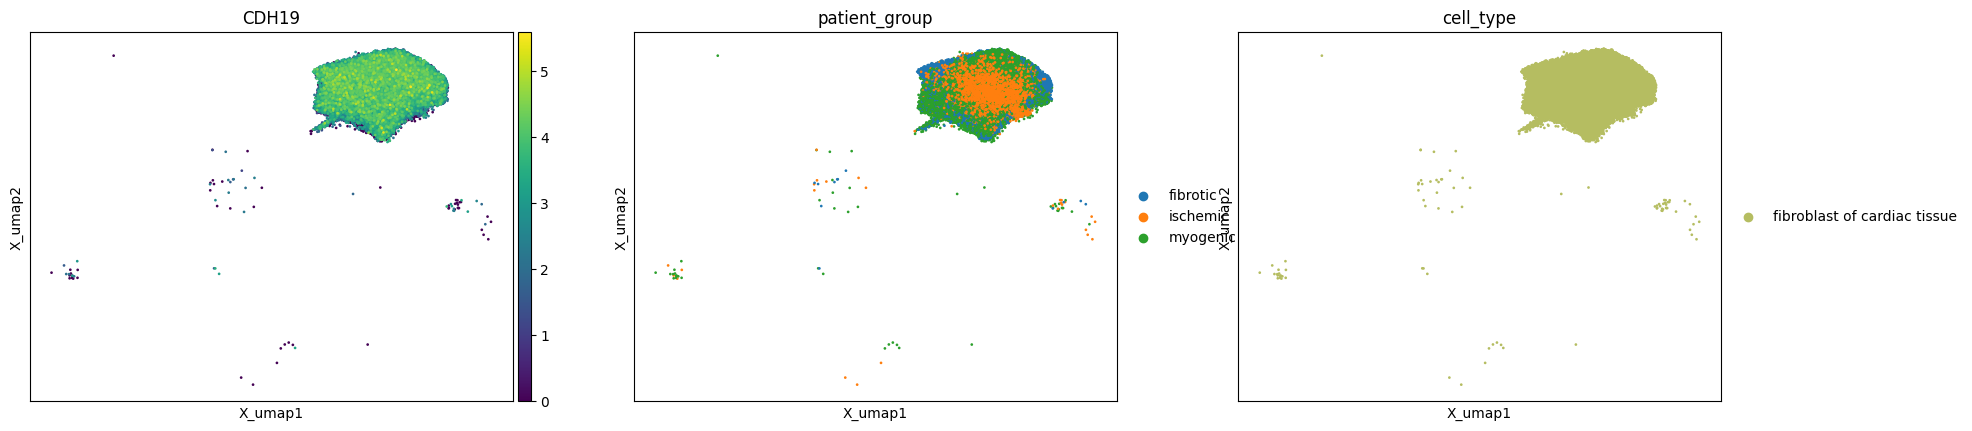

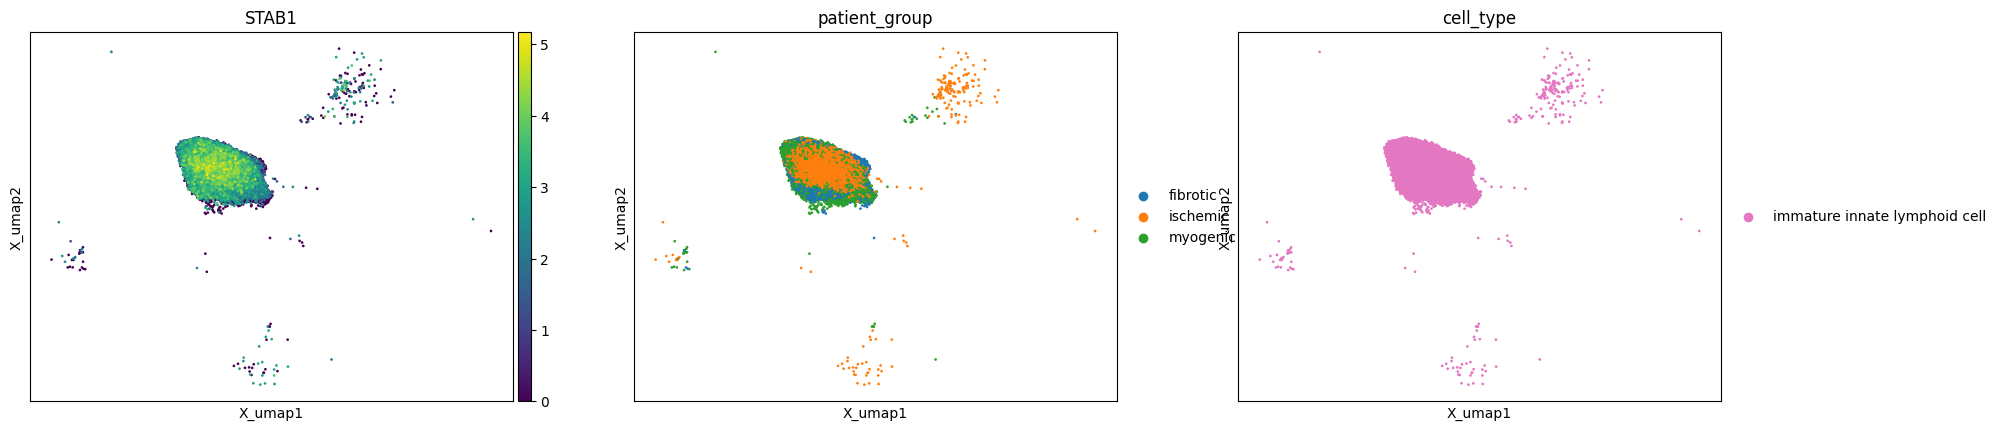

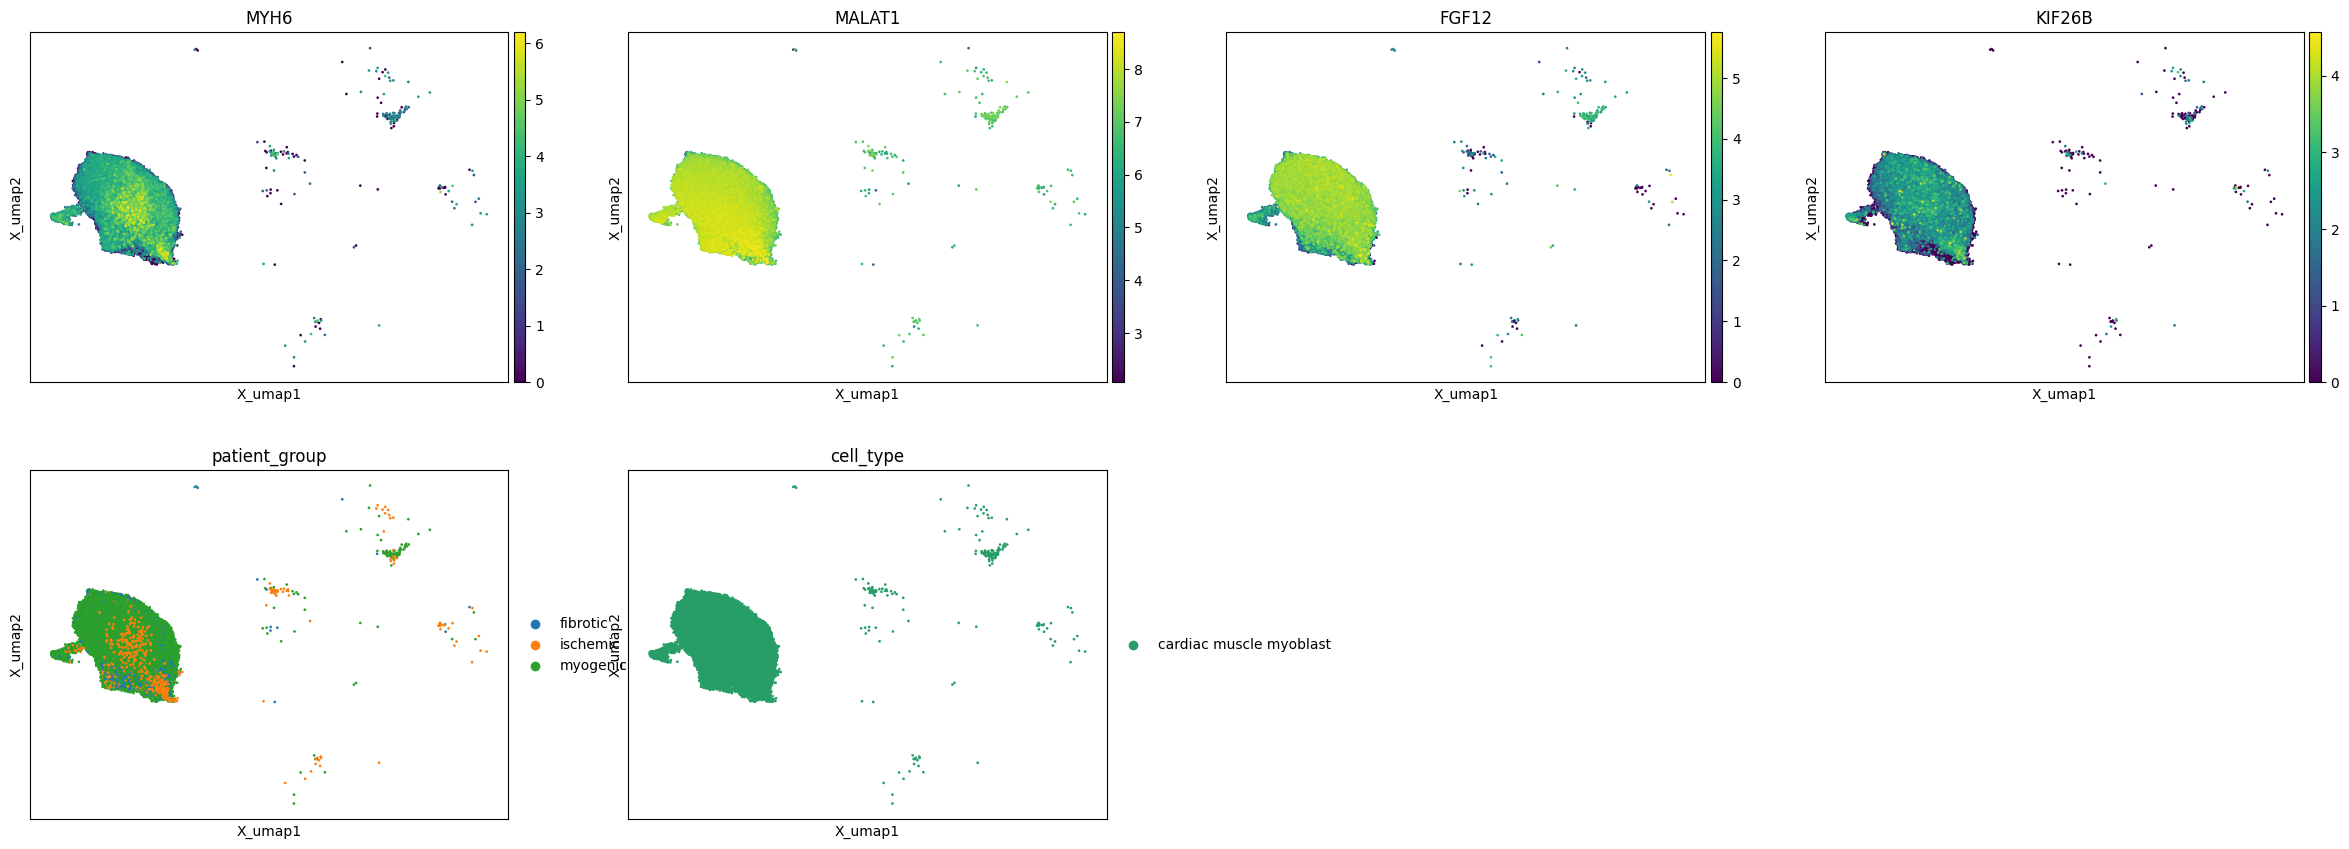

In [185]:
emb = "X_umap"

for celltype in selected_genes.keys():
    # Subset view of cell type 
    sub_adata = adata[adata.obs["cell_type"]==celltype]

    # Plot embedding on subset of cell type
    sc.pl.embedding(sub_adata,basis=emb,color=selected_genes[celltype]+["patient_group","cell_type"],
                    gene_symbols="feature_name", use_raw=False, s=15) 